# 1. Document Classification

In [48]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2.4.1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
import csv
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## (a) Preprocess

In [83]:
author_encode = {'fd':0, 'acd': 1, 'ja': 2}

In [99]:
def import_data(filepaths_dict):
    
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words, max_features=500)
#     lst_all = []
    x_all = []
    y_all = []
    
    for author, filepath in filepaths_dict.items():
        # get rows from .txt file
        with open(filepath) as f:
            reader = f.read()
            reader = reader.split("\n\n")

            x_all.extend(reader)
            y_all.extend([author_encode[author]] * len(reader))
            
            print(f"author {author} has {len(reader)} samples")
                
    
    return x_all, y_all



Run the functions defined above

In [100]:
filepaths_dict = {'fd': './a4-data/q1/fd.txt',
            'acd': './a4-data/q1/acd.txt',
            'ja': './a4-data/q1/ja.txt'}

x, y = import_data(filepaths_dict)

author fd has 6055 samples
author acd has 2548 samples
author ja has 11495 samples


In [101]:
y_arr = np.array(y)
y = tf.keras.utils.to_categorical(y_arr, num_classes=3)

In [102]:
assert(len(x) == len(y) == 6055+2548+11495)

In [103]:
stop_words = set(stopwords.words('english'))
for paragraph in x:
    paragraph = paragraph.replace('\n', '')
    # remove punctuation
    paragraph = re.sub(r'[^\w\s]', '', paragraph)
    paragraph = re.sub(' \d+', '', paragraph)
    
# vectorize and transform the sentences into matrices that indicate the precence of the top 4000 words
tfidf_vectorizer = TfidfVectorizer(stop_words = list(stop_words), max_features=4000)
x_vec = tfidf_vectorizer.fit_transform(x)
print("Fitted a TF-IDF Vectorizer on the training data")

Fitted a TF-IDF Vectorizer on the training data


In [104]:
# x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=500)


In [105]:
print(f"The samples are distributed as class0, class1, class2: {sum(y==1)}")

The samples are distributed as class0, class1, class2: [ 6055  2548 11495]


### Split into training and testing

In [106]:
x_train, x, y_train, y = train_test_split(x_vec, y, test_size=0.3, random_state=42, stratify=y_arr)

In [107]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.333, random_state=28)

In [151]:
print("Sizes of sets:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

Sizes of sets:
x_train: (14000, 4000)
y_train: (14000, 3)
x_val: (4000, 4000)
y_val: (4000, 3)
x_test (2000, 4000)
y_test (2000,)


There is an obscure bug with the Tensorflow + CuDNN install for GPUs that occurs when there is a remainder when creating batches of data. To avoid this error, I adjusted the dataset lengths.
Feel free to skip the cell directly below this box if you're not using a GPU for training.

In [109]:
x_train = x_train[0:14000]
y_train = y_train[0:14000]
x_val = x_val[0:4000]
y_val = y_val[0:4000]
x_test = x_test[0:2000]
y_test = y_test[0:2000]

In [110]:
num_samples = x_train.shape[0]
num_features = x_train.shape[1]
num_classes = y_train.shape[1]

print("num_features:", num_features)

num_features: 4000


## Logistic Regression

### Define model

In [111]:
def compute_loss(yhat, y, weights):
    batch_size = yhat.shape[0]
    celoss = (-1/batch_size) * np.sum(y * np.log(yhat)) + (regularization * np.sum(np.square(weights)))
    return celoss

def compute_grad(yhat, y_train, x_train, weights):
    batch_size = yhat.shape[0]
    grad = (1/batch_size) * (x_train.transpose() @ (yhat - y_train)) + (2*regularization) * weights  
    return grad

def adjust_weights(weights, grad, lr):
    weights[:] = weights - lr * grad
    return weights

def labels_to_vectors(yhat, yreal):
    assert(yhat.shape == yreal.shape)
    pred = np.argmax(yhat, axis=1)
    real = np.argmax(yreal, axis=1)
    return pred, real

def evaluate_accuracy(pred, real):
    assert(pred.shape == real.shape)
    return (np.sum(pred == real)) / pred.shape[0]

In [112]:
def softmax(y_linear):
    num = np.exp(y_linear)
    norms = np.sum(num, axis=1)
    norms = np.expand_dims(norms, axis=1)   
    return num/norms

def compute_prediction(x_train, weights):
    y_linear = x_train @ weights
    yhat = softmax(y_linear)
    return yhat

### Train Logistic regression model using minibatch GD

In [138]:
MB_history = {'reg=0.01' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
             'reg=0.001' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
            'reg=0.0001': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
              }

In [141]:
epochs = 100
lr = 0.001
reg_params = [0.001, 0.0001]
batch_size = 100

for regularization in reg_params:
    
#     weights_MB = np.random.rand(num_features, num_classes)
    
    for epoch in range(epochs):
        cum_loss = 0

        for i in range(0, num_samples, batch_size):

            x = x_train[i:i+batch_size, :]
            y = y_train[i:i+batch_size, :]

            yhat = compute_prediction(x, weights_MB)
            loss = compute_loss(yhat, y, weights_MB)
            cum_loss += loss

            grad = compute_grad(yhat, y, x, weights_MB)
            weights = adjust_weights(weights_MB, grad, lr)

            
        pred = compute_prediction(x_train, weights_MB)

        pred, real = labels_to_vectors(pred, y_train)
        train_acc = evaluate_accuracy(pred, real)
        train_loss = cum_loss / (num_samples//batch_size)

        y_val_pred = compute_prediction(x_val, weights)
        val_loss = compute_loss(y_val_pred, y_val, weights_MB)
        pred, real = labels_to_vectors(y_val_pred, y_val)
        val_acc = evaluate_accuracy(pred, real)



        print("Epoch", epoch, "reg=", regularization, "   train_loss:", round(train_loss, 4), "train_acc:", round(train_acc, 5), "   val_loss:", round(val_loss, 4), "val_acc:", round(val_acc,5))
        MB_history[str('reg=' + str(regularization))]['train_loss'].append(train_loss)
        MB_history[str('reg=' + str(regularization))]['train_acc'].append(train_acc)
        MB_history[str('reg=' + str(regularization))]['val_loss'].append(val_loss)
        MB_history[str('reg=' + str(regularization))]['val_acc'].append(val_acc)

        

Epoch 0 reg= 0.001    train_loss: 3.4315 train_acc: 0.81793    val_loss: 3.4559 val_acc: 0.7935
Epoch 1 reg= 0.001    train_loss: 3.43 train_acc: 0.81793    val_loss: 3.4544 val_acc: 0.7935
Epoch 2 reg= 0.001    train_loss: 3.4285 train_acc: 0.81793    val_loss: 3.4529 val_acc: 0.7935
Epoch 3 reg= 0.001    train_loss: 3.427 train_acc: 0.81793    val_loss: 3.4513 val_acc: 0.7935
Epoch 4 reg= 0.001    train_loss: 3.4255 train_acc: 0.81793    val_loss: 3.4498 val_acc: 0.7935
Epoch 5 reg= 0.001    train_loss: 3.424 train_acc: 0.81793    val_loss: 3.4483 val_acc: 0.7935
Epoch 6 reg= 0.001    train_loss: 3.4225 train_acc: 0.81793    val_loss: 3.4468 val_acc: 0.7935
Epoch 7 reg= 0.001    train_loss: 3.421 train_acc: 0.81793    val_loss: 3.4453 val_acc: 0.7935
Epoch 8 reg= 0.001    train_loss: 3.4195 train_acc: 0.81793    val_loss: 3.4438 val_acc: 0.7935
Epoch 9 reg= 0.001    train_loss: 3.418 train_acc: 0.818    val_loss: 3.4423 val_acc: 0.7935
Epoch 10 reg= 0.001    train_loss: 3.4165 train_

Epoch 90 reg= 0.001    train_loss: 3.2989 train_acc: 0.81829    val_loss: 3.323 val_acc: 0.79375
Epoch 91 reg= 0.001    train_loss: 3.2974 train_acc: 0.81836    val_loss: 3.3216 val_acc: 0.79375
Epoch 92 reg= 0.001    train_loss: 3.296 train_acc: 0.81836    val_loss: 3.3201 val_acc: 0.79375
Epoch 93 reg= 0.001    train_loss: 3.2946 train_acc: 0.81836    val_loss: 3.3187 val_acc: 0.79375
Epoch 94 reg= 0.001    train_loss: 3.2931 train_acc: 0.81836    val_loss: 3.3173 val_acc: 0.79375
Epoch 95 reg= 0.001    train_loss: 3.2917 train_acc: 0.81843    val_loss: 3.3158 val_acc: 0.79375
Epoch 96 reg= 0.001    train_loss: 3.2903 train_acc: 0.81843    val_loss: 3.3144 val_acc: 0.79375
Epoch 97 reg= 0.001    train_loss: 3.2888 train_acc: 0.81843    val_loss: 3.313 val_acc: 0.79375
Epoch 98 reg= 0.001    train_loss: 3.2874 train_acc: 0.81843    val_loss: 3.3115 val_acc: 0.79375
Epoch 99 reg= 0.001    train_loss: 3.286 train_acc: 0.81843    val_loss: 3.3101 val_acc: 0.79375
Epoch 0 reg= 0.0001    t

Epoch 74 reg= 0.0001    train_loss: 0.8111 train_acc: 0.81871    val_loss: 0.836 val_acc: 0.79425
Epoch 75 reg= 0.0001    train_loss: 0.8111 train_acc: 0.81871    val_loss: 0.836 val_acc: 0.79425
Epoch 76 reg= 0.0001    train_loss: 0.811 train_acc: 0.81871    val_loss: 0.836 val_acc: 0.79425
Epoch 77 reg= 0.0001    train_loss: 0.811 train_acc: 0.81871    val_loss: 0.836 val_acc: 0.79425
Epoch 78 reg= 0.0001    train_loss: 0.811 train_acc: 0.81871    val_loss: 0.8359 val_acc: 0.7945
Epoch 79 reg= 0.0001    train_loss: 0.811 train_acc: 0.81871    val_loss: 0.8359 val_acc: 0.7945
Epoch 80 reg= 0.0001    train_loss: 0.8109 train_acc: 0.81871    val_loss: 0.8359 val_acc: 0.7945
Epoch 81 reg= 0.0001    train_loss: 0.8109 train_acc: 0.81871    val_loss: 0.8359 val_acc: 0.7945
Epoch 82 reg= 0.0001    train_loss: 0.8109 train_acc: 0.81871    val_loss: 0.8358 val_acc: 0.7945
Epoch 83 reg= 0.0001    train_loss: 0.8109 train_acc: 0.81871    val_loss: 0.8358 val_acc: 0.7945
Epoch 84 reg= 0.0001    

### Plot results

In [129]:
def plot_loss(history, title):
    plt.plot(history['train_loss'], color='y', label='training loss')
    plt.plot(history['val_loss'], color='r', label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()

In [130]:
def plot_accuracy(history, title):
    plt.plot(history['train_acc'], color='y', label='training accuracy')
    plt.plot(history['val_acc'], color='r', label='validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()    

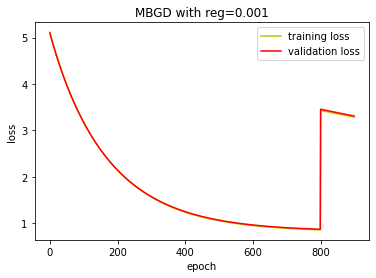

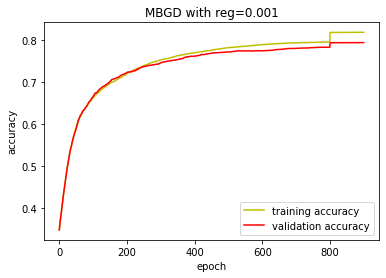

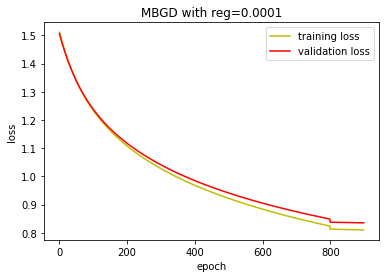

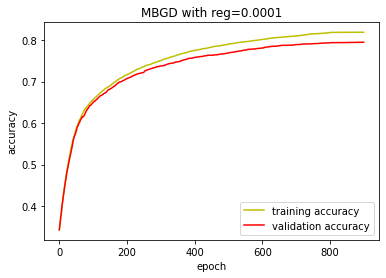

In [142]:
for reg in reg_params:
    plot_loss(MB_history[str('reg=' + str(reg))], str('MBGD with reg=' + str(reg)))
    plot_accuracy(MB_history[str('reg=' + str(reg))], str('MBGD with reg=' + str(reg)))

## (d) Report Recall, Precision, F1 
for each class on the test data

In [154]:

y_pred = np.argmax(compute_prediction(x_test, weights), axis=1)


In [155]:
y_test = np.argmax(y_test, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [156]:
print(y_test.shape)
print(y_pred.shape)

(2000,)
(2000,)


In [157]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       592
           1       0.74      0.25      0.37       260
           2       0.81      0.91      0.86      1148

    accuracy                           0.79      2000
   macro avg       0.77      0.65      0.67      2000
weighted avg       0.78      0.79      0.77      2000



## Multilayer Perceptron

In [247]:

def sigmoid(x):
    h = 1 / (1 + np.exp(-x))
    return h

def sigmoid_grad(z):
    return sigmoid(z) * (1 - sigmoid(z))

def compute_loss_nn(yhat, y):
    batch_size = yhat.shape[0]
    celoss = (-1/batch_size) * np.sum(y * np.log(yhat)) #+ ((-lam/batch_size) * (np.sum(np.square(theta1)) + np.sum(np.square(theta2)))))
    return celoss

def predict(x, theta1, theta2):
    z_2 = x @ theta1.transpose()
    a_2 = sigmoid(z_2)
    a_2 = np.c_[np.ones(a_2.shape[0]), a_2]
    z_3 = a_2 @ theta2.transpose()
    a_3 = sigmoid(z_3)
    return a_3

In [248]:
MLP_MB_history = {'hiddennodes=10' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
    'hiddennodes=25' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
                  'hiddennodes=5' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
              'hiddennodes=100' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
                  'hiddennodes=200' :{'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
              }

In [249]:
epochs = 200
lam = 0.4
lr = 0.1
hidden_layer_options = [5]
batch_size = 64

for hidden_nodes in hidden_layer_options:
    
    # initialize weights
    theta1 = np.random.rand(hidden_nodes, num_features)
    theta2 = np.random.randn(num_classes, hidden_nodes+1)
    
    for epoch in range(epochs):
        cum_loss = 0
        
        for i in range(0, num_samples, batch_size):
            x = x_train[i: i+batch_size, :]
            y = y_train[i: i+batch_size, :]
            
            z_2 = x @ theta1.transpose()
            a_2 = sigmoid(z_2)

            a_2 = np.c_[np.ones(a_2.shape[0]), a_2]

            z_3 = a_2 @ theta2.transpose()

            a_3 = sigmoid(z_3)

            delta_3 = a_3 - y

            delta_2 = (delta_3 @ theta2) * np.c_[np.ones(z_2.shape[0]), sigmoid_grad(z_2)]
            delta_2 = delta_2[:, 1:]

            theta1_grad = (1/batch_size) * (delta_2.transpose() @ x) #+ ( (lam/(2*batch_size)) * theta1)
            theta2_grad = (1/batch_size) * (delta_3.transpose() @ a_2) #+ ( (lam/(2*batch_size)) * theta2)

            loss = compute_loss_nn(a_3, y)
            cum_loss += loss

            # Adjust weights
            theta1 = theta1[:] - lr * theta1_grad
            theta2 = theta2[:] - lr * theta2_grad

        train_loss = cum_loss / (num_samples / batch_size)
        pred = predict(x_train, theta1, theta2)
        pred, real = labels_to_vectors(pred, y_train)
        train_acc = evaluate_accuracy(pred, real)

        y_val_pred = predict(x_val, theta1, theta2)
        val_loss = compute_loss_nn(y_val_pred, y_val)
        pred, real = labels_to_vectors(y_val_pred, y_val)
        val_acc = evaluate_accuracy(pred, real)


        print("Epoch", epoch, "trained on ", hidden_nodes, "hidden nodes,   train_loss:", round(train_loss, 4), "train_acc:", round(train_acc, 5), "   val_loss:", round(val_loss, 4), "val_acc:", round(val_acc,5))
        MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))]['train_loss'].append(train_loss)
        MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))]['train_acc'].append(train_acc)
        MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))]['val_loss'].append(val_loss)
        MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))]['val_acc'].append(val_acc)

Epoch 0 trained on  5 hidden nodes,   train_loss: 1.0249 train_acc: 0.57186    val_loss: 0.9424 val_acc: 0.572
Epoch 1 trained on  5 hidden nodes,   train_loss: 0.9432 train_acc: 0.57186    val_loss: 0.9407 val_acc: 0.572
Epoch 2 trained on  5 hidden nodes,   train_loss: 0.9416 train_acc: 0.57186    val_loss: 0.9391 val_acc: 0.572
Epoch 3 trained on  5 hidden nodes,   train_loss: 0.9402 train_acc: 0.57186    val_loss: 0.9377 val_acc: 0.572
Epoch 4 trained on  5 hidden nodes,   train_loss: 0.939 train_acc: 0.57186    val_loss: 0.9364 val_acc: 0.572
Epoch 5 trained on  5 hidden nodes,   train_loss: 0.9378 train_acc: 0.57186    val_loss: 0.9353 val_acc: 0.572
Epoch 6 trained on  5 hidden nodes,   train_loss: 0.9367 train_acc: 0.57186    val_loss: 0.9342 val_acc: 0.572
Epoch 7 trained on  5 hidden nodes,   train_loss: 0.9357 train_acc: 0.57186    val_loss: 0.9331 val_acc: 0.572
Epoch 8 trained on  5 hidden nodes,   train_loss: 0.9347 train_acc: 0.57186    val_loss: 0.9321 val_acc: 0.572
Ep

Epoch 75 trained on  5 hidden nodes,   train_loss: 0.4778 train_acc: 0.82536    val_loss: 0.5246 val_acc: 0.79875
Epoch 76 trained on  5 hidden nodes,   train_loss: 0.4722 train_acc: 0.82721    val_loss: 0.5204 val_acc: 0.801
Epoch 77 trained on  5 hidden nodes,   train_loss: 0.4668 train_acc: 0.82929    val_loss: 0.5163 val_acc: 0.80275
Epoch 78 trained on  5 hidden nodes,   train_loss: 0.4615 train_acc: 0.83129    val_loss: 0.5123 val_acc: 0.8055
Epoch 79 trained on  5 hidden nodes,   train_loss: 0.4562 train_acc: 0.83271    val_loss: 0.5083 val_acc: 0.807
Epoch 80 trained on  5 hidden nodes,   train_loss: 0.4511 train_acc: 0.83457    val_loss: 0.5045 val_acc: 0.808
Epoch 81 trained on  5 hidden nodes,   train_loss: 0.4461 train_acc: 0.83643    val_loss: 0.5008 val_acc: 0.809
Epoch 82 trained on  5 hidden nodes,   train_loss: 0.4411 train_acc: 0.83879    val_loss: 0.4972 val_acc: 0.81
Epoch 83 trained on  5 hidden nodes,   train_loss: 0.4363 train_acc: 0.8405    val_loss: 0.4936 val_

Epoch 150 trained on  5 hidden nodes,   train_loss: 0.2357 train_acc: 0.92164    val_loss: 0.3619 val_acc: 0.86925
Epoch 151 trained on  5 hidden nodes,   train_loss: 0.2342 train_acc: 0.92229    val_loss: 0.361 val_acc: 0.8695
Epoch 152 trained on  5 hidden nodes,   train_loss: 0.2327 train_acc: 0.92286    val_loss: 0.3602 val_acc: 0.8695
Epoch 153 trained on  5 hidden nodes,   train_loss: 0.2312 train_acc: 0.92343    val_loss: 0.3594 val_acc: 0.87
Epoch 154 trained on  5 hidden nodes,   train_loss: 0.2297 train_acc: 0.92393    val_loss: 0.3586 val_acc: 0.87025
Epoch 155 trained on  5 hidden nodes,   train_loss: 0.2283 train_acc: 0.92464    val_loss: 0.3578 val_acc: 0.8705
Epoch 156 trained on  5 hidden nodes,   train_loss: 0.2269 train_acc: 0.92514    val_loss: 0.3571 val_acc: 0.8705
Epoch 157 trained on  5 hidden nodes,   train_loss: 0.2255 train_acc: 0.92586    val_loss: 0.3564 val_acc: 0.87075
Epoch 158 trained on  5 hidden nodes,   train_loss: 0.2241 train_acc: 0.9265    val_loss

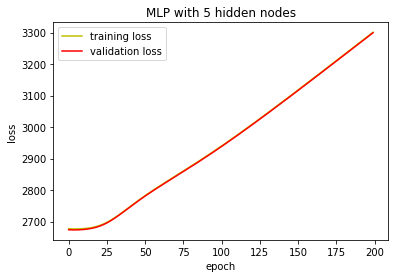

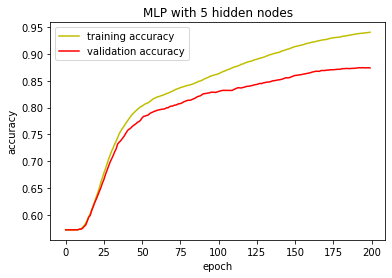

In [237]:
for hidden_nodes in hidden_layer_options:
    plot_loss(MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))], str('MLP with ' + str(hidden_nodes) + ' hidden nodes'))
    plot_accuracy(MLP_MB_history[str('hiddennodes=' + str(hidden_nodes))], str('MLP with ' + str(hidden_nodes) + ' hidden nodes'))

## (d) Report Recall, Precision, F1 
for each class on the test data

In [238]:
y_pred = np.argmax(predict(x_test, theta1, theta2), axis=1)

In [239]:
print(y_test.shape)
print(y_pred.shape)

(2000,)
(2000,)


In [240]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       592
           1       0.76      0.56      0.65       260
           2       0.88      0.96      0.92      1148

    accuracy                           0.87      2000
   macro avg       0.84      0.79      0.81      2000
weighted avg       0.87      0.87      0.87      2000

